## 1. Import The Required Libraries

In [180]:
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.ndimage import label, distance_transform_edt, gaussian_filter, center_of_mass
import numpy as np
from skimage.feature import peak_local_max
from skimage.color import label2rgb
from skimage.segmentation import watershed
from skimage.measure import regionprops
from skimage.morphology import remove_small_objects
import math
from collections import defaultdict

In [181]:
def label_mask(mask, structure = np.ones((3, 3, 3), dtype=int)):
  """
  This function taked the binary mask and returns the labeled mask using 26 connectivity rule to ensure that all the lesion is labeled even if it has other components in other slices.
  """
  return label(mask, structure= structure)

## 2. Load Sample of The Dataset

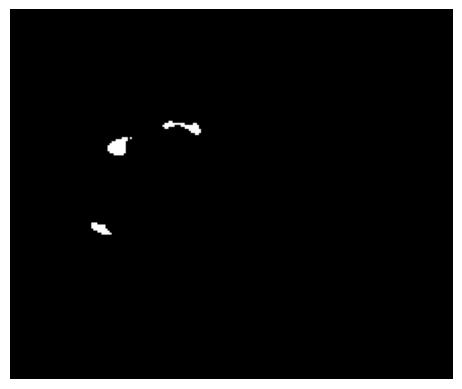

In [182]:
T1_img = nib.load(r"MSLesSeg Dataset/train/P9/T1/P9_T1_MASK.nii.gz").get_fdata()  #The baseline data mask (change the directory to test different images)
T2_img = nib.load(r"MSLesSeg Dataset/train/P9/T2/P9_T2_MASK.nii.gz").get_fdata() # Follow up data mask
plt.imshow(T1_img[:, :, 80], cmap='gray' ) #showing the middle slice
plt.axis('off')
plt.show()

## 3. Added Two synthetic lesions to test connected-component labeling

---



In [183]:
def label_to_color_with_ids(label_img):
    H, W = label_img.shape
    colored_img = np.zeros((H, W, 3), dtype=np.uint8)

    # Unique labels (exclude background)
    unique_labels = np.unique(label_img)
    unique_labels = unique_labels[unique_labels > 0]


    rng = np.random.default_rng(0)

    for lbl in unique_labels:
        color = rng.integers(50, 255, size=3, dtype=np.uint8)
        colored_img[label_img == lbl] = color

    return colored_img

# Labeling the Follow up 

## split detection:

### for the split detection, we used the Graph theory.


*   Each lesion in the baseline and follow up is cosidered as vertex
*   If there's overlap between a lesion in the follow up and baseline, add edge between them.
* A lesion is cosidered split if it has two edges connected to it.

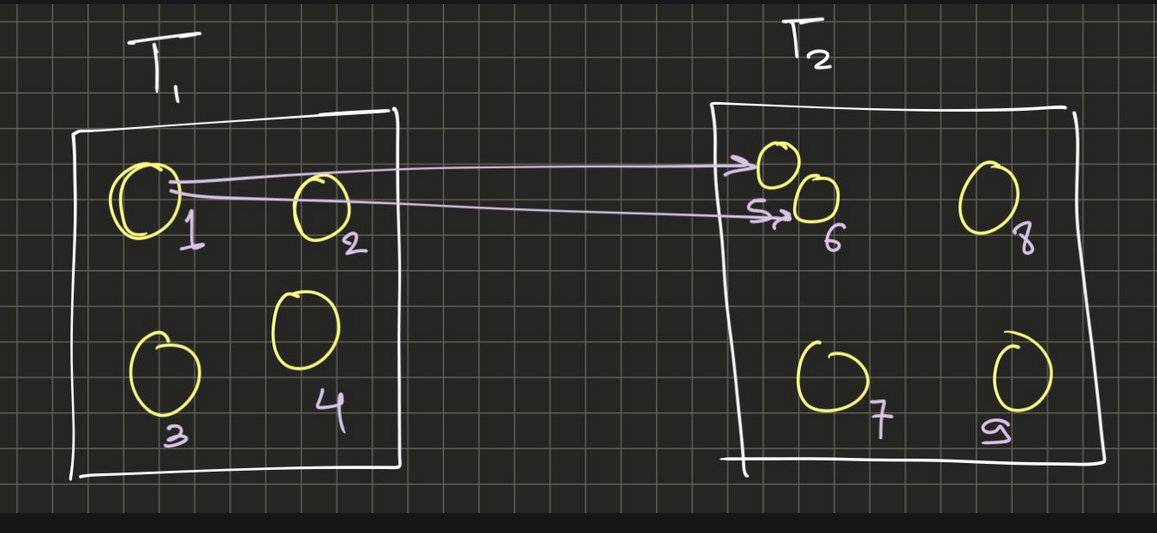

Here we can see that lesion number one has two children


In [184]:
labeled_T1, num_T1 = label_mask(T1_img)
labeled_T2, num_T2 = label_mask(T2_img)

In [185]:
def lesion_sizes(labels):
  # This function returns the number of voxels in each lesion
    ids, counts = np.unique(labels, return_counts=True)
    return dict(zip(ids, counts))

size_1 = lesion_sizes(labeled_T1)
size_2 = lesion_sizes(labeled_T2)


what about the merging situation?

In [186]:
def compute_overlap_map(labels_A, labels_B):
    """
    returns:
      overlap[(A_id, B_id)] = intersection voxel count
    """
    overlap = {}

    A_ids = np.unique(labels_A)
    A_ids = A_ids[A_ids != 0]

    for A in A_ids:
        mask_A = labels_A == A
        overlapping_B = labels_B[mask_A]

        B_ids, counts = np.unique(overlapping_B, return_counts=True)
        for B, cnt in zip(B_ids, counts):
            if B == 0:
                continue
            overlap[(A, B)] = cnt

    return overlap

overlap = compute_overlap_map(labeled_T1, labeled_T2)

print("\n=== Overlap Debug ===")
print(f"Total overlap pairs found: {len(overlap)}")

for (A, B), inter in sorted(overlap.items()):
    score = inter / min(size_1[A], size_2[B])
    if score >= 0.1:  # This threshold is to ensure it's not just a segmentation error
        print(f"  A={A}, B={B}: intersection={inter}, score={score:.3f}, "
              f"size_A={size_1[A]}, size_B={size_2[B]}")


=== Overlap Debug ===
Total overlap pairs found: 12
  A=2, B=1: intersection=911, score=0.932, size_A=977, size_B=1836
  A=3, B=2: intersection=643, score=0.836, size_A=769, size_B=793
  A=4, B=1: intersection=227, score=0.828, size_A=274, size_B=1836
  A=5, B=4: intersection=26, score=0.591, size_A=44, size_B=70
  A=7, B=8: intersection=67, score=0.817, size_A=113, size_B=82
  A=7, B=10: intersection=16, score=0.327, size_A=113, size_B=49
  A=9, B=12: intersection=171, score=0.609, size_A=281, size_B=282
  A=10, B=14: intersection=52, score=0.912, size_A=76, size_B=57
  A=11, B=15: intersection=58, score=0.547, size_A=129, size_B=106
  A=12, B=17: intersection=42, score=0.667, size_A=72, size_B=63
  A=13, B=20: intersection=324, score=0.913, size_A=481, size_B=355
  A=14, B=21: intersection=25, score=0.658, size_A=38, size_B=46


In [187]:
def detect_splits(overlap, size_A, size_B, tau=0.2):
    """
    returns:
      splits[A_id] = list of B_ids
    """


    splits = defaultdict(list)

    for (A, B), inter in overlap.items():
        score = inter / min(size_A[A], size_B[B])
        if score >= tau:
            splits[A].append((B, inter))

    # keep only true splits
    return {
        A: Bs for A, Bs in splits.items()
        if len(Bs) >= 2
    }
splits = detect_splits(overlap, size_1, size_2)
for A, children in splits.items():
    print(f"  Lesion {A} → {len(children)} children: {children}")

  Lesion 7 → 2 children: [(8, 67), (10, 16)]


In [188]:
def assign_split_ids(A_id, children, next_id_fn=None):
    """
    children: list of (B_id, intersection_count)
    returns:
      {B_id -> final_id}
    """
    # sort by intersection size
    children = sorted(children, key=lambda x: x[1], reverse=True)

    mapping = {}
    mapping[children[0][0]] = A_id  # largest keeps ID

    for i, (B, _) in enumerate(children[1:], start=1):
        mapping[B] = A_id

    return mapping


## Merging Situation:
When two lesions merge, The largest lesion takes the id in the follow-up and the smaller lesion(s) are considered to have disappeared. Both lesions will have the status "merged" in the follow-up. 

In [189]:
def merge_handling(overlap, size_A, size_B, tau=0.2):
    """
    returns:
      merges[B_id] = list of A_ids
    """

    merges = defaultdict(list)

    for (A, B), inter in overlap.items():
        score = inter / min(size_A[A], size_B[B])
        if score >= tau:
            merges[B].append((A, inter))

    # keep only true merges
    return {
        B: As for B, As in merges.items()
        if len(As) >= 2
    }
    
merges = merge_handling(overlap, size_1, size_2)
for B, parents in merges.items():
    print(f"  Lesion {B} ← {len(parents)} parents: {parents}")

  Lesion 1 ← 2 parents: [(2, 911), (4, 227)]


In [190]:
import stat


labels_B_final = np.zeros_like(labeled_T2, dtype=object)

processed_B = set()
volumes = {}
status = {}


# STEP 1: Handle SPLITS first
for A, children in splits.items():
    volume = sum(size_2[B] for B, _ in children)
    mapping = assign_split_ids(A, children)
    print(f"Split detected: Lesion {A} → {list(mapping.values())}")
    for B, final_id in mapping.items():
        print(f"  Assigning lesion {B} to ID {final_id}")
        labels_B_final[labeled_T2 == B] = final_id
        processed_B.add(B)
    volumes[A] = volume  # Update volume of the lesion to be the sum of split lesions
    status[A] = 'split'

# STEP 2: Handle NORMAL overlaps (non-splits)
tau = 0.1

for (A, B), inter in overlap.items():
    if B in processed_B:
        continue
    score = inter / min(size_1[A], size_2[B])
    if score >= tau: # This is a continuing lesion (not a split)
        volumes[A] = size_2[B]
        if volumes[A] / size_1[A] >= 1.25:
            status[A] = 'enlarged'
        elif volumes[A] / size_1[A] <= 0.75:
            status[A] = 'shrinking'
        else:
            status[A] = 'present'
        labels_B_final[labeled_T2 == B] = A
        processed_B.add(B)
    
        
# STEP 3: Handle MERGES
for B, parents in merges.items():
    if B in processed_B:
        continue
    
    # Assign the ID of the largest parent lesion
    largest_parent = max(parents, key=lambda x: size_1[x[0]])[0]
    labels_B_final[labeled_T2 == B] = largest_parent
    
    volumes[largest_parent] = sum(size_1[p[0]] for p in parents) # Update volume of the lesion to be the sum of parent lesions
    status[largest_parent] = 'merged'
    for p in parents:
        if p[0] != largest_parent:
            volumes[p[0]] = 0  # Merged lesions lose their individual volume
            status[p[0]] = 'merged'
            
    processed_B.add(B)
    print(f"Merge detected: Lesion {B} from parents {[p[0] for p in parents]} assigned to {largest_parent}")

# STEP 4: Handle NEW lesions (no overlap)
next_new_id = int(np.max(labeled_T1)) + 1

for B in np.unique(labeled_T2):
    if B == 0:
        continue
        
    if B not in processed_B:
        # This is a new lesion with no significant overlap
        labels_B_final[labeled_T2 == B] = next_new_id
        status[next_new_id] = 'new'
        volumes[next_new_id] = size_2[B]
        print(f"New lesion detected: {next_new_id}")
        next_new_id += 1
        


Split detected: Lesion 7 → [7, 7]
  Assigning lesion 8 to ID 7
  Assigning lesion 10 to ID 7
New lesion detected: 15
New lesion detected: 16
New lesion detected: 17
New lesion detected: 18
New lesion detected: 19
New lesion detected: 20
New lesion detected: 21
New lesion detected: 22
New lesion detected: 23
New lesion detected: 24


In [191]:
volumes

{7: 131,
 2: 1836,
 3: 793,
 5: 70,
 9: 282,
 10: 57,
 11: 106,
 12: 63,
 13: 355,
 14: 46,
 15: 40,
 16: 48,
 17: 196,
 18: 56,
 19: 32,
 20: 149,
 21: 45,
 22: 110,
 23: 2,
 24: 208}

In [192]:
def visualize_longitudinal_labels_side_by_side(
    labels_A,
    labels_B,
    slice_idx,
    title_A="Baseline",
    title_B="Follow-up"
):
    """
    Visualize two labeled masks (baseline & follow-up) side by side
    using label_to_color_with_ids.
    """

    # --- extract slices safely ---
    if labels_A.ndim == 3:
        slice_A = labels_A[:, :, slice_idx]
    else:
        slice_A = labels_A

    if labels_B.ndim == 3:
        slice_B = labels_B[:, :, slice_idx]
    else:
        slice_B = labels_B

    # --- colorize using YOUR function ---
    colored_A = label_to_color_with_ids(slice_A)
    colored_B = label_to_color_with_ids(slice_B)

    # --- plot ---
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    for ax, colored, labels, title in zip(
        axes,
        [colored_A, colored_B],
        [slice_A, slice_B],
        [f"{title_A} – slice {slice_idx}", f"{title_B} – slice {slice_idx}"]
    ):
        ax.set_facecolor("black")
        ax.imshow(colored)
        ax.axis("off")
        ax.set_title(title)

        # --- draw IDs ---
        for lbl in np.unique(labels):
            if lbl == 0:
                continue

            ys, xs = np.where(labels == lbl)
            if len(xs) == 0:
                continue

            cy, cx = int(ys.mean()), int(xs.mean())
            ax.text(
                cx, cy, str(lbl),
                color="red",
                fontsize=10,
                weight="bold",
                ha="center",
                va="center"
            )

    plt.tight_layout()
    plt.show()


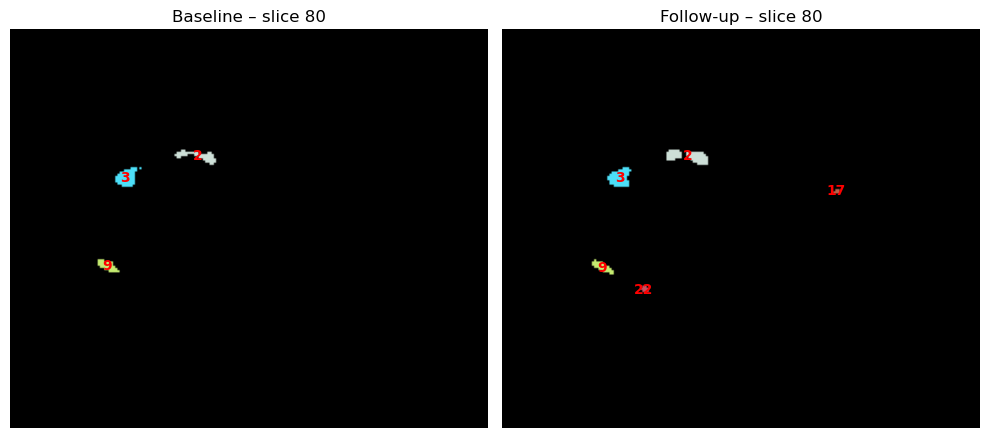

In [193]:
visualize_longitudinal_labels_side_by_side(
    labels_A=labeled_T1,
    labels_B=labels_B_final,
    slice_idx= 80 # Change this to view different slices
)


In [194]:
def save(img_dir, labeled_mask, out_path):
  """
  This function takes the mask and saves the labeled output image to view them in fsl.
  """
  img = nib.load(img_dir)

  labeled_to_save = nib.Nifti1Image(
        labeled_mask.astype(np.int32),
        affine=img.affine,
        header=img.header
    )

  labeled_to_save.set_data_dtype(np.int32)

  nib.save(labeled_to_save, out_path)


## Summary Table Generation:
Each Lesion Object in the Baseline and Follow-up has an ID and a status from these:
- Present: The lesion is present in the scan.
- Absent: The lesion is not present in the scan.
- New: The lesion is newly identified in the follow-up scan.
- Merged: The lesion has merged with another lesion in the follow-up scan.
- Split: The lesion has split into multiple lesions in the follow-up scan.
- Enelarged: The size increased to 25% or more.
- Shrinking: The size decreased to 25% or more.

In [195]:
import pandas as pd
from py import process
from traitlets import All


def build_lesion_summary_tables(
    size_1,          # {A: volume at baseline}
    final_volumes,   # {The final volumes}
    overlap,         # {(A,B): intersection}
    splits,          # {A: [B1, B2, ...]}
    merges,          # {B: [(A1, inter1), (A2, inter2), ...]}
    labeled_T1,      # baseline labeled volume
    labeled_T2,      # follow-up labeled volume, 
    status,         # {lesion_id: status}
    enlarge_thr=1.25,
    shrink_thr=0.75
):
    """
    Returns:
      baseline_table: pd.DataFrame
      followup_table: pd.DataFrame
    """
    
    # Step 1: Baseline tabke
    A_ids = set(np.unique(labeled_T1))
    A_ids = A_ids - {0}  # Just to exclude the background
    baseline_rows = []
    for A in A_ids: 
        baseline_rows.append({
            "Lesion ID": A,
            "Baseline Volume (voxels)": size_1.get(A, 0),
            "Status": status.get(A, "Absent")
        })
    baseline_table = pd.DataFrame(baseline_rows)
    
    # Step 2: Follow-up table
    B_ids = set(np.unique(labeled_T2))
    B_ids = B_ids - {0}
    All_lesions = A_ids.union(B_ids)
    followup_rows = []
    
    for lesion_id in All_lesions:
        followup_rows.append({
            "Lesion ID": lesion_id,
            "Follow-up Volume (voxels)": final_volumes.get(lesion_id, 0),
            "Status": status.get(lesion_id, "Absent")
        })
    followup_table = pd.DataFrame(followup_rows)
    return baseline_table, followup_table

In [196]:
baseline_table, followup_table = build_lesion_summary_tables(
    size_1=size_1,
    final_volumes=volumes,
    overlap=overlap,
    splits=splits,
    merges=merges,
    labeled_T1=labeled_T1,
    labeled_T2= labels_B_final, 
    status= status
)

In [197]:
followup_table

,Lesion ID,Follow-up Volume (voxels),Status
0,1,0,Absent
1,2,1836,enlarged
2,3,793,present
3,4,0,Absent
4,5,70,enlarged
5,6,0,Absent
6,7,131,split
7,8,0,Absent
8,9,282,present
9,10,57,shrinking


In [198]:
baseline_table

,Lesion ID,Baseline Volume (voxels),Status
0,1,3,Absent
1,2,977,enlarged
2,3,769,present
3,4,274,Absent
4,5,44,enlarged
5,6,35,Absent
6,7,113,split
7,8,1,Absent
8,9,281,present
9,10,76,shrinking
